In [28]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import geopandas as gpd
import os
import math
from shapely.geometry import shape
from scipy.stats import wilcoxon
%matplotlib inline

In [2]:
os.chdir(r'D:\pku\UES\GlobalForestVerticalStructure\China_plantation_natural_forest\0702')
veg_file = r'.\veg_class\china_veg_region_WGS84.shp'
raw_file_path = 'china_grids_result3.csv'
factor_path = 'china_grids_envs_natplt_soil2.csv'

In [3]:
df = pd.read_csv(raw_file_path)

In [4]:
df_ava_a = df[((df['n_rh25']!='[]') & (df['p_rh25']!='[]'))]
df_ava_b = df[((df['n_cover']!='[]') & (df['p_cover']!='[]'))]

In [5]:
# first footprints check
df_ava_a_n = (eval(i) for i in df_ava_a['n_rh25'].values)
df_ava_a_n = [item for sublist in df_ava_a_n for item in sublist]
df_ava_a_p = (eval(i) for i in df_ava_a['p_rh25'].values)
df_ava_a_p = [item for sublist in df_ava_a_p for item in sublist]
print('#L2A','planted forest footprints',len(df_ava_a_p),'natural forest footprints',len(df_ava_a_n))
df_ava_b_n = (eval(i) for i in df_ava_b['n_cover'].values)
df_ava_b_n = [item for sublist in df_ava_b_n for item in sublist]
df_ava_b_p = (eval(i) for i in df_ava_a['p_cover'].values)
df_ava_b_p = [item for sublist in df_ava_b_p for item in sublist]
print('#L2A','planted forest footprints',len(df_ava_b_p),'natural forest footprints',len(df_ava_b_n))
print(len(df),len(df_ava_a),len(df_ava_b))

#L2A planted forest footprints 7199468 natural forest footprints 26171534
#L2A planted forest footprints 6820985 natural forest footprints 25503894
6600 2593 2580


In [ ]:
df_ava_a.iloc[1,:]

In [6]:
#prepare data frame to store new results
df_L2A = pd.DataFrame(dtype = float)
df_L2B = pd.DataFrame(dtype = float)

In [7]:
def random_mean(s,dataframe):
    length = len(dataframe)
    sample_index = np.random.choice(length, size=1000, replace=True, p=None)
    sample_data = dataframe.iloc[sample_index,:].mean()
    return sample_data

In [10]:
#L2A ~21min
df_ava_a_length = len(df_ava_a)
for i in range(0,df_ava_a_length):
    rh_all_i = df_ava_a.iloc[i,]
    #print(rh_all_i['system:index'])
    nat_rh_all_i = pd.DataFrame({
        'n_ele':eval(rh_all_i['n_ele_a']),
        'n_rh98':eval(rh_all_i['n_rh98']),
    })
    plt_rh_all_i = pd.DataFrame({
        'p_ele':eval(rh_all_i['p_ele_a']),
        'p_rh98':eval(rh_all_i['p_rh98']),
    })
    #control sample
    
    if len(nat_rh_all_i['n_rh98']) < 50 or len(plt_rh_all_i['p_rh98']) < 50:
        #print(i,'omit',len(nat_rh_all_i['n_ele']))
        continue

    # #3std filter
    # if 0:
    #     nat_rh_all_i_mean = nat_rh_all_i.mean()['n_rh98']
    #     nat_rh_all_i_std = nat_rh_all_i.std()['n_rh98']
    #     plt_rh_all_i_mean = plt_rh_all_i.mean()['p_rh98']
    #     plt_rh_all_i_std = plt_rh_all_i.std()['p_rh98']
    #     #rh98 only- if rh98 is outlier then others must be
    #     plt_rh_all_i = plt_rh_all_i[(plt_rh_all_i['p_rh98']>plt_rh_all_i_mean-3*plt_rh_all_i_std) & (plt_rh_all_i['p_rh98']<plt_rh_all_i_mean+3*plt_rh_all_i_std)]
    #     nat_rh_all_i = nat_rh_all_i[(nat_rh_all_i['n_rh98']>nat_rh_all_i_mean-3*nat_rh_all_i_std) & (nat_rh_all_i['n_rh98']<nat_rh_all_i_mean+3*nat_rh_all_i_std)]
        
    if 1:
        ele_all = pd.concat([nat_rh_all_i['n_ele'],plt_rh_all_i['p_ele']])
        ele_p10 = np.percentile(ele_all, 10)
        ele_p90 = np.percentile(ele_all, 90)
        n_ele_min = min(nat_rh_all_i['n_ele'])
        p_ele_min = min(plt_rh_all_i['p_ele'])
        n_ele_max = max(nat_rh_all_i['n_ele'])
        p_ele_max = max(plt_rh_all_i['p_ele'])
        ele_min = max(n_ele_min,p_ele_min,ele_p10)
        ele_max = min(n_ele_max,p_ele_max,ele_p90)

        #sort by n_ele
        nat_rh_all_i = nat_rh_all_i.sort_values(by=['n_ele'])
        plt_rh_all_i = plt_rh_all_i.sort_values(by=['p_ele'])

        #remove outside ele range
        nat_rh_all_i = nat_rh_all_i[(nat_rh_all_i['n_ele']>ele_min) & (nat_rh_all_i['n_ele']<ele_max)]
        plt_rh_all_i = plt_rh_all_i[(plt_rh_all_i['p_ele']>ele_min) & (plt_rh_all_i['p_ele']<ele_max)]

        min_sample_num = min(len(nat_rh_all_i),len(plt_rh_all_i))
        if min_sample_num < 50 :
            continue

    # if 0:
    #     #systematic sampling
    #     nat_sample_index = np.linspace(0,len(nat_rh_all_i)-1,min_sample_num,dtype=int)
    #     plt_sample_index = np.linspace(0,len(plt_rh_all_i)-1,min_sample_num,dtype=int)

    #     #calculate mean and std of each column and save to a new dataframe
    #     nat_rh_all_i_mean = nat_rh_all_i.iloc[nat_sample_index,:].mean()
    #     plt_rh_all_i_mean = plt_rh_all_i.iloc[plt_sample_index,:].mean()

    #bootstrap
    if 1:
        nat_rh_all_i_mean = np.full((1000,2),np.nan)
        plt_rh_all_i_mean = np.full((1000,2),np.nan)
        
        nat_rh_all_i_mean = np.apply_along_axis(random_mean,1,nat_rh_all_i_mean,dataframe = nat_rh_all_i)
        nat_rh_all_i_mean = np.nanmean(nat_rh_all_i_mean,axis=0)
        plt_rh_all_i_mean = np.apply_along_axis(random_mean,1,plt_rh_all_i_mean,dataframe = plt_rh_all_i)
        plt_rh_all_i_mean = np.nanmean(plt_rh_all_i_mean,axis=0)        
        
        #for n in range(1000):
        #    nat_rh_all_i_sample = np.random.choice(len(nat_rh_all_i), size=min_sample_num, replace=True, p=None) 
        #    plt_rh_all_i_sample = np.random.choice(len(plt_rh_all_i), size=min_sample_num, replace=True, p=None)
        #    nat_rh_all_i_mean[n] = (nat_rh_all_i.iloc[nat_rh_all_i_sample,:].mean())
        #    plt_rh_all_i_mean[n] = (plt_rh_all_i.iloc[plt_rh_all_i_sample,:].mean())

    #nat_rh_shannon = shannon_diversity_index_with_bins(nat_rh_all_i.iloc[nat_sample_index,:]['n_rh98'],5)
    #plt_rh_shannon = shannon_diversity_index_with_bins(plt_rh_all_i.iloc[plt_sample_index,:]['p_rh98'],5)

    #save result to df_new
    df_L2A.loc[i,'id'] = rh_all_i['system:index']
    df_L2A.loc[i,'min_sample_num_a'] = min_sample_num
    df_L2A.loc[i,'n_rh98_mean'] = nat_rh_all_i_mean[1]
    df_L2A.loc[i,'p_rh98_mean'] = plt_rh_all_i_mean[1]

In [ ]:
#test
#nat_rh_all_i_mean = np.full((1000,2),np.nan)
#def random_mean(s,dataframe):
#    length = len(dataframe)
#    sample_index = np.random.choice(length, size=1000, replace=True, p=None)
#    sample_data = dataframe.iloc[sample_index,:].mean()
#    return sample_data
#nat_rh_all_i_mean = np.apply_along_axis(random_mean,1,nat_rh_all_i_mean,dataframe = nat_rh_all_i)
#nat_rh_all_i_mean = np.nanmean(nat_rh_all_i_mean,axis=0)

In [11]:
df_L2A.to_csv(r'df_L2A.csv')

In [ ]:
rh_all_i.head()

In [23]:
#get length of eachcolumn
print(len(eval(rh_all_i['p_ele_b'])))
print(len(eval(rh_all_i['p_fhd_normal'])))
print(len(eval(rh_all_i['p_pai'])))
print(len(eval(rh_all_i['p_cover'])))


3892
3840
3840
3840


In [8]:
#L2B ~30min
df_ava_b_length = len(df_ava_b)
for i in range(0,df_ava_b_length):
    rh_all_i = df_ava_b.iloc[i,]
    nat_rh_all_i = pd.DataFrame({
        'n_ele':eval(rh_all_i['n_ele_b']),
        'n_fhd_normal':eval(rh_all_i['n_fhd_normal']),
        'n_pai':eval(rh_all_i['n_pai']),
        'n_cover':eval(rh_all_i['n_cover']),
    })
    plt_rh_all_i = pd.DataFrame({
        'p_ele':eval(rh_all_i['p_ele_b']),
        'p_fhd_normal':eval(rh_all_i['p_fhd_normal']),
        'p_pai':eval(rh_all_i['p_pai']),
        'p_cover':eval(rh_all_i['p_cover']),
    })
    #control sample
    
    if len(nat_rh_all_i['n_fhd_normal']) < 50 or len(plt_rh_all_i['p_fhd_normal']) < 50:
        continue
    
    if 1:
        ele_all = pd.concat([nat_rh_all_i['n_ele'],plt_rh_all_i['p_ele']])
        ele_p10 = np.percentile(ele_all, 10)
        ele_p90 = np.percentile(ele_all, 90)
        n_ele_min = min(nat_rh_all_i['n_ele'])
        p_ele_min = min(plt_rh_all_i['p_ele'])
        n_ele_max = max(nat_rh_all_i['n_ele'])
        p_ele_max = max(plt_rh_all_i['p_ele'])
        ele_min = max(n_ele_min,p_ele_min,ele_p10)
        ele_max = min(n_ele_max,p_ele_max,ele_p90)

        #sort by n_ele
        nat_rh_all_i = nat_rh_all_i.sort_values(by=['n_ele'])
        plt_rh_all_i = plt_rh_all_i.sort_values(by=['p_ele'])

        #remove outside ele range
        nat_rh_all_i = nat_rh_all_i[(nat_rh_all_i['n_ele']>ele_min) & (nat_rh_all_i['n_ele']<ele_max)]
        plt_rh_all_i = plt_rh_all_i[(plt_rh_all_i['p_ele']>ele_min) & (plt_rh_all_i['p_ele']<ele_max)]

        min_sample_num = min(len(nat_rh_all_i),len(plt_rh_all_i))
        if min_sample_num < 50:
            continue
        
    # if 0:
    #     #systematic sampling
    #     nat_sample_index = np.linspace(0,len(nat_rh_all_i)-1,min_sample_num,dtype=int)
    #     plt_sample_index = np.linspace(0,len(plt_rh_all_i)-1,min_sample_num,dtype=int)

    #     #calculate mean and std of each column and save to a new dataframe
    #     nat_rh_all_i_mean = nat_rh_all_i.iloc[nat_sample_index,:].mean()
    #     plt_rh_all_i_mean = plt_rh_all_i.iloc[plt_sample_index,:].mean()
        
    #bootstrap
    if 1:
        nat_rh_all_i_mean = np.full((1000,2),np.nan)
        plt_rh_all_i_mean = np.full((1000,2),np.nan)
        
        nat_rh_all_i_mean = np.apply_along_axis(random_mean,1,nat_rh_all_i_mean,dataframe = nat_rh_all_i)
        nat_rh_all_i_mean = np.nanmean(nat_rh_all_i_mean,axis=0)
        plt_rh_all_i_mean = np.apply_along_axis(random_mean,1,plt_rh_all_i_mean,dataframe = plt_rh_all_i)
        plt_rh_all_i_mean = np.nanmean(plt_rh_all_i_mean,axis=0)    

    #save result to df_new
    df_L2B.loc[i,'id'] = rh_all_i['system:index']
    df_L2B.loc[i,'min_sample_num_b'] = min_sample_num
    df_L2B.loc[i,'n_fhd_mean'] = nat_rh_all_i_mean[1]
    df_L2B.loc[i,'n_pai_mean'] = nat_rh_all_i_mean[2]
    df_L2B.loc[i,'n_cov_mean'] = nat_rh_all_i_mean[3]
    df_L2B.loc[i,'p_fhd_mean'] = plt_rh_all_i_mean[1]
    df_L2B.loc[i,'p_pai_mean'] = plt_rh_all_i_mean[2]
    df_L2B.loc[i,'p_cov_mean'] = plt_rh_all_i_mean[3]


In [9]:
df_L2B.to_csv(r'df_L2B.csv')

In [12]:
#merge 
df_new = df_L2A.merge(df_L2B,on='id',how='outer')
df_new.to_csv(r'df_AB.csv')

In [ ]:
df_test_result = pd.DataFrame(dtype = float)
range_i = range(20,500,1)
def ttest_rel_mean_dif(a,b):
    test_p = stats.ttest_rel(a,b).pvalue
    mean_diff = a.mean() - b.mean()
    return test_p,mean_diff
for i in range_i:
    df_test_a = df_L2A[df_L2A['min_sample_num_a'] >= i]
    df_test_b = df_L2B[df_L2B['min_sample_num_b'] >= i]

    ttest_rh98, rh98_mean_diff = ttest_rel_mean_dif(df_test_a['n_rh98_mean'],df_test_a['p_rh98_mean'])
    ttest_fhd, fhd_mean_diff = ttest_rel_mean_dif(df_test_b['n_fhd_mean'],df_test_b['p_fhd_mean'])
    ttest_pai, pai_mean_diff = ttest_rel_mean_dif(df_test_b['n_pai_mean'],df_test_b['p_pai_mean'])
    ttest_cov, cov_mean_diff = ttest_rel_mean_dif(df_test_b['n_cov_mean'],df_test_b['p_cov_mean'])
    
    df_test_result.loc[i-20,'rh98_ttest_p'] = ttest_rh98
    df_test_result.loc[i-20,'rh98_mean_diff'] = rh98_mean_diff

    df_test_result.loc[i-20,'fhd_ttest_p'] = ttest_fhd
    df_test_result.loc[i-20,'fhd_mean_diff'] = fhd_mean_diff

    df_test_result.loc[i-20,'pai_ttest_p'] = ttest_pai
    df_test_result.loc[i-20,'pai_mean_diff'] = pai_mean_diff

    df_test_result.loc[i-20,'cov_ttest_p'] = ttest_cov
    df_test_result.loc[i-20,'cov_mean_diff'] = cov_mean_diff

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


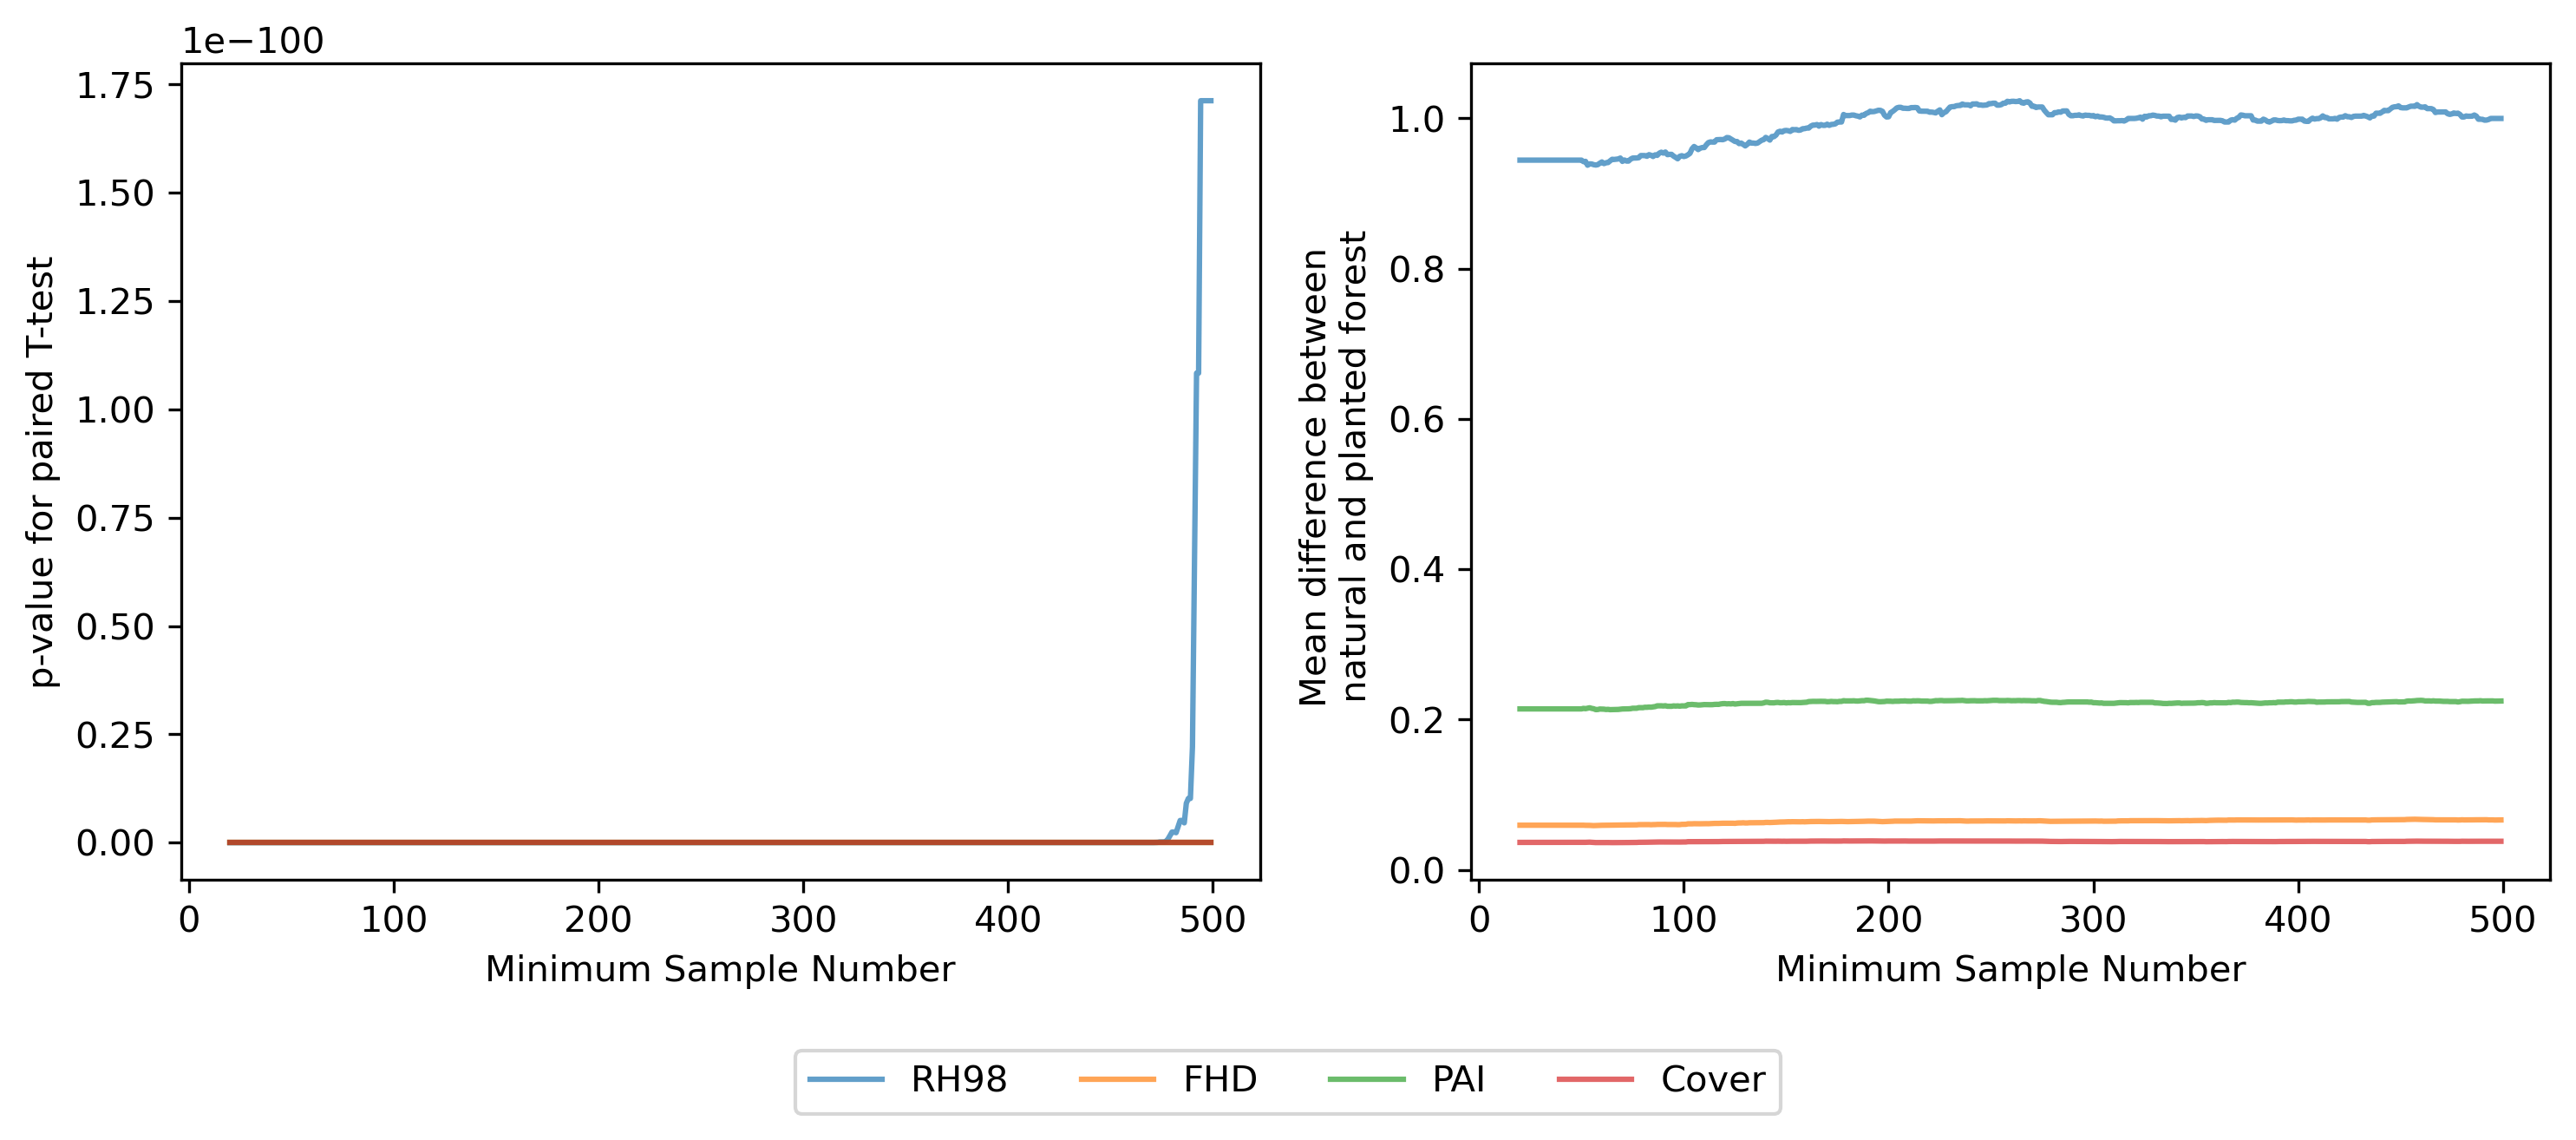

In [ ]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

# First subplot
axs[0].plot(np.array(range_i), df_test_result['rh98_ttest_p'], alpha=0.7)
axs[0].plot(np.array(range_i), df_test_result['fhd_ttest_p'], alpha=0.7)
axs[0].plot(np.array(range_i), df_test_result['pai_ttest_p'], alpha=0.7)
axs[0].plot(np.array(range_i), df_test_result['cov_ttest_p'], alpha=0.7)
axs[0].set_xlabel('Minimum Sample Number')
axs[0].set_ylabel('p-value for paired T-test')

# Second subplot
axs[1].plot(np.array(range_i), df_test_result['rh98_mean_diff'], alpha=0.7)
axs[1].plot(np.array(range_i), df_test_result['fhd_mean_diff'], alpha=0.7)
axs[1].plot(np.array(range_i), df_test_result['pai_mean_diff'], alpha=0.7)
axs[1].plot(np.array(range_i), df_test_result['cov_mean_diff'], alpha=0.7)
axs[1].set_xlabel('Minimum Sample Number')
axs[1].set_ylabel('Mean difference between \n natural and planted forest')

# Hide the legends in the individual subplots
for ax in axs.flat:
    ax.legend().set_visible(False)

# Create a single legend for the entire figure
fig.legend(['RH98', 'FHD', 'PAI', 'Cover'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

In [31]:
#wilcoxon
df_test_result = pd.DataFrame(dtype = float)
range_i = range(20,500,1)
def wilcoxon_rel_mean_dif(a,b):
    test_p = stats.wilcoxon(a,b).pvalue
    mean_diff = a.mean() - b.mean()
    return test_p,mean_diff
for i in range_i:
    df_test_a = df_L2A[df_L2A['min_sample_num_a'] >= i]
    df_test_b = df_L2B[df_L2B['min_sample_num_b'] >= i]

    test_rh98, rh98_mean_diff = wilcoxon_rel_mean_dif(df_test_a['n_rh98_mean'],df_test_a['p_rh98_mean'])
    test_fhd, fhd_mean_diff = wilcoxon_rel_mean_dif(df_test_b['n_fhd_mean'],df_test_b['p_fhd_mean'])
    test_pai, pai_mean_diff = wilcoxon_rel_mean_dif(df_test_b['n_pai_mean'],df_test_b['p_pai_mean'])
    test_cov, cov_mean_diff = wilcoxon_rel_mean_dif(df_test_b['n_cov_mean'],df_test_b['p_cov_mean'])
    
    df_test_result.loc[i-20,'rh98_ttest_p'] = test_rh98
    df_test_result.loc[i-20,'rh98_mean_diff'] = rh98_mean_diff

    df_test_result.loc[i-20,'fhd_ttest_p'] = test_fhd
    df_test_result.loc[i-20,'fhd_mean_diff'] = fhd_mean_diff

    df_test_result.loc[i-20,'pai_ttest_p'] = test_pai
    df_test_result.loc[i-20,'pai_mean_diff'] = pai_mean_diff

    df_test_result.loc[i-20,'cov_ttest_p'] = test_cov
    df_test_result.loc[i-20,'cov_mean_diff'] = cov_mean_diff

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


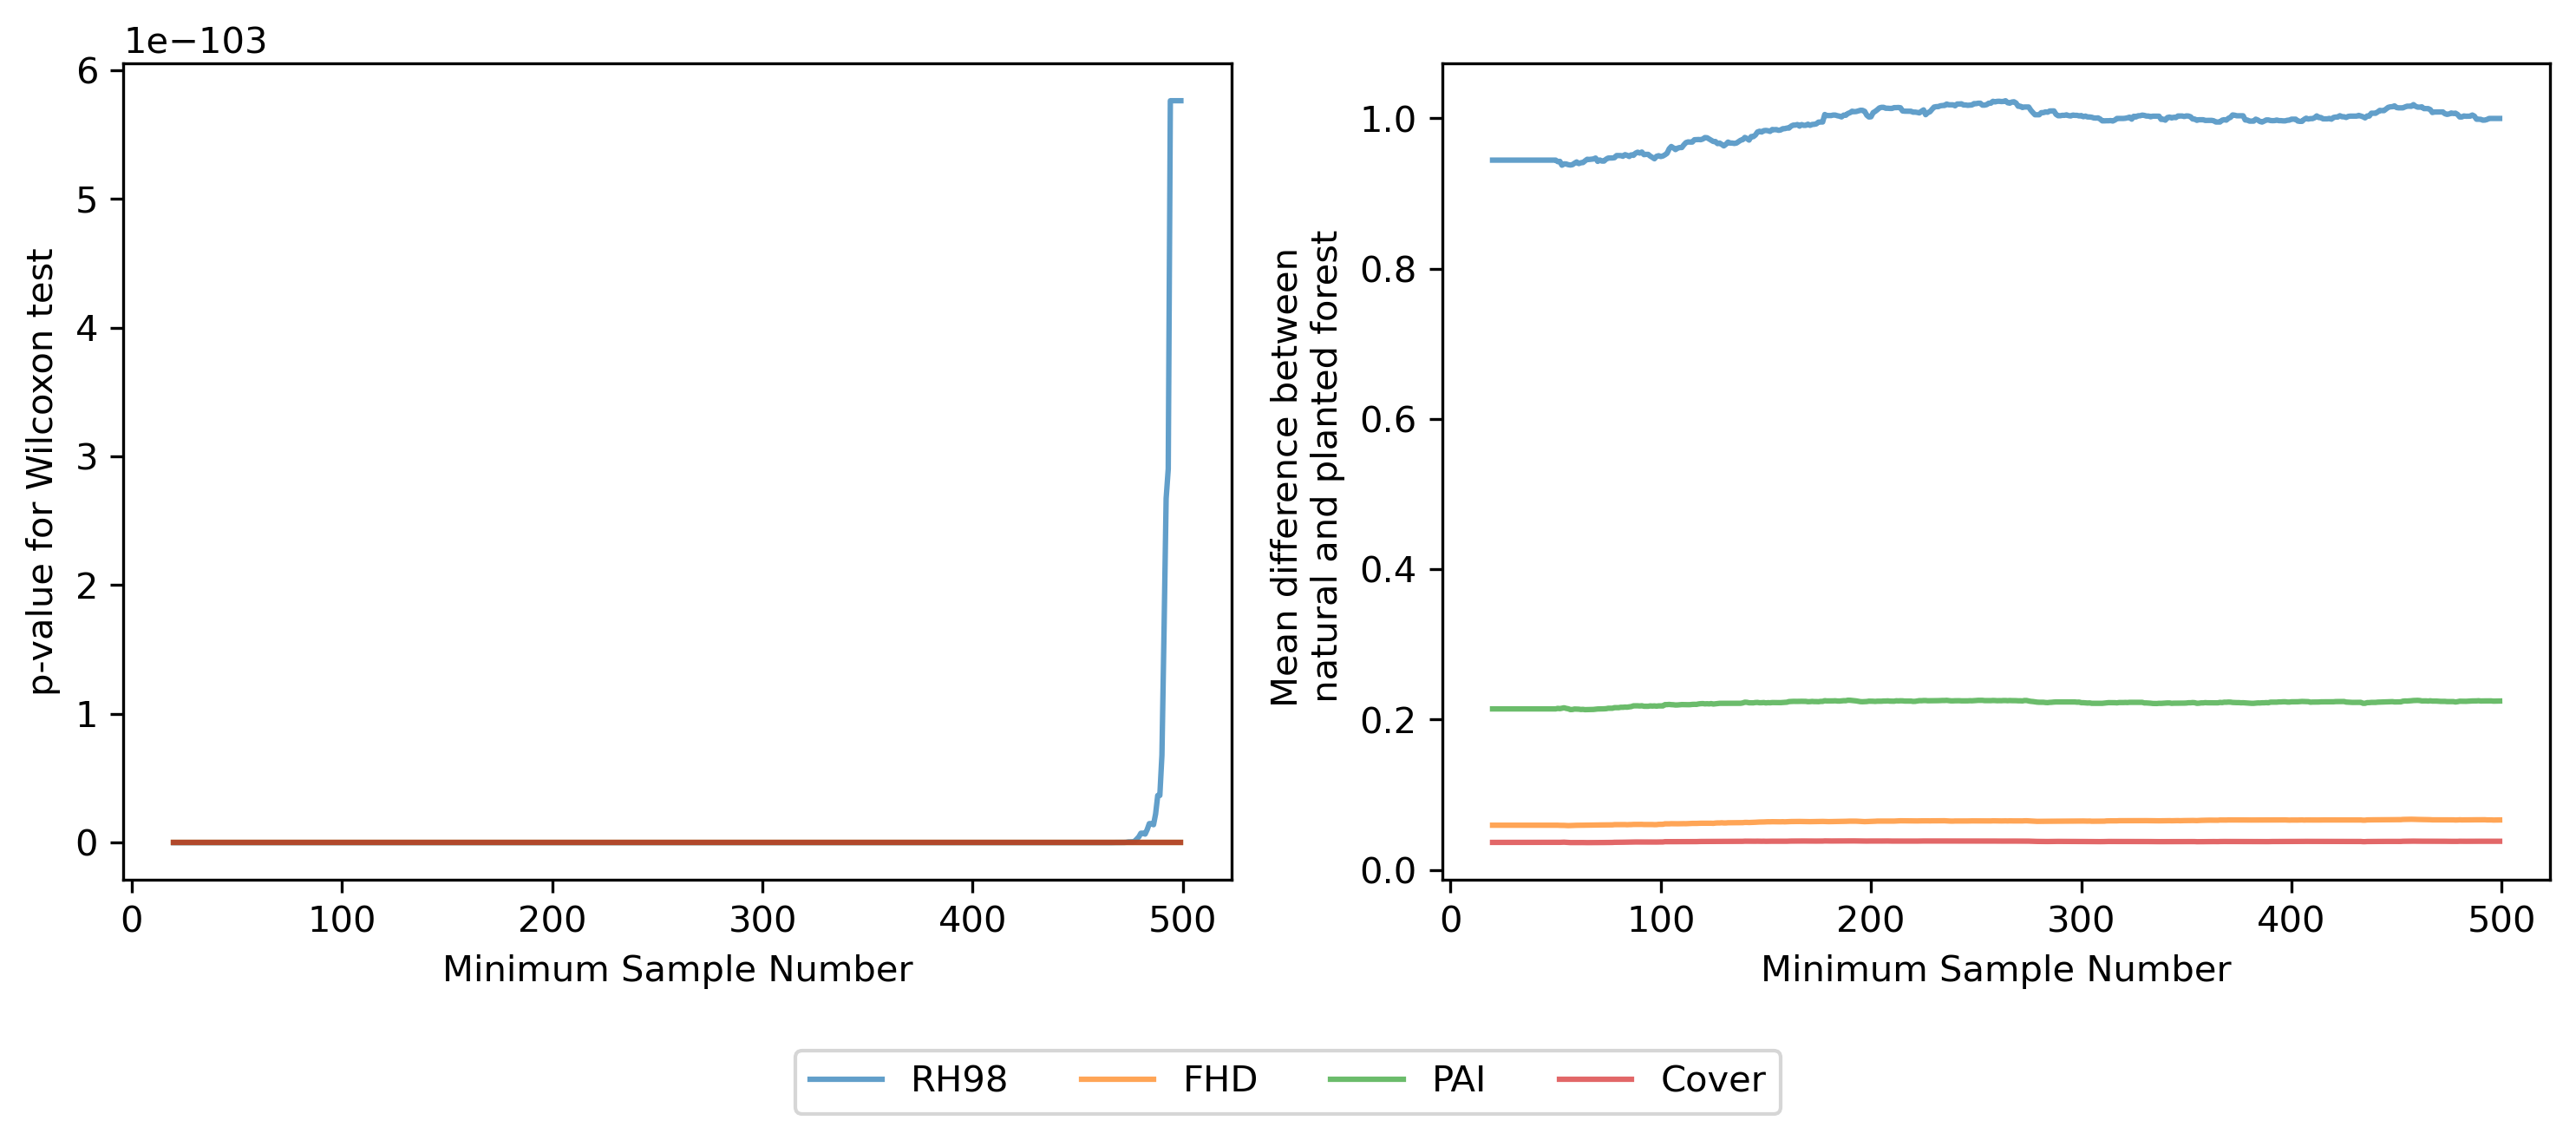

In [33]:
fig, axs = plt.subplots(1, 2, figsize=(10, 4), dpi=300)

# First subplot
axs[0].plot(np.array(range_i), df_test_result['rh98_ttest_p'], alpha=0.7)
axs[0].plot(np.array(range_i), df_test_result['fhd_ttest_p'], alpha=0.7)
axs[0].plot(np.array(range_i), df_test_result['pai_ttest_p'], alpha=0.7)
axs[0].plot(np.array(range_i), df_test_result['cov_ttest_p'], alpha=0.7)
axs[0].set_xlabel('Minimum Sample Number')
axs[0].set_ylabel('p-value for Wilcoxon test')

# Second subplot
axs[1].plot(np.array(range_i), df_test_result['rh98_mean_diff'], alpha=0.7)
axs[1].plot(np.array(range_i), df_test_result['fhd_mean_diff'], alpha=0.7)
axs[1].plot(np.array(range_i), df_test_result['pai_mean_diff'], alpha=0.7)
axs[1].plot(np.array(range_i), df_test_result['cov_mean_diff'], alpha=0.7)
axs[1].set_xlabel('Minimum Sample Number')
axs[1].set_ylabel('Mean difference between \n natural and planted forest')

# Hide the legends in the individual subplots
for ax in axs.flat:
    ax.legend().set_visible(False)

# Create a single legend for the entire figure
fig.legend(['RH98', 'FHD', 'PAI', 'Cover'], loc='lower center', ncol=4, bbox_to_anchor=(0.5, -0.1))

plt.tight_layout()
plt.show()

In [ ]:
df_new_backup = df_new.copy()

In [37]:
df_new = pd.read_csv(r'df_AB.csv')

In [38]:
#second footprints check
df_new = df_new[(df_new['min_sample_num_b'] >= 50)&(df_new['min_sample_num_a'] >= 50)]

print(sum(df_new.loc[(df_new['min_sample_num_a'] >= 100), 'min_sample_num_a']))
print(sum(df_new.loc[(df_new['min_sample_num_b'] >= 100), 'min_sample_num_a']))

print(len(df_new))

2581142.0
2579369.0
1965


In [39]:
veg_class = gpd.read_file(veg_file)
df_factors = pd.read_csv(factor_path)
df_factors.rename(columns={'system:index':'id'},inplace=True)
df_factors = df_factors[df_factors['id'].isin(df_new['id'])]
df_new_factors = df_new.merge(df_factors,how='inner',on='id')
df_new_factors = df_new_factors.merge(df.rename(columns={'system:index':'id'})[['id','.geo']],how='inner',on='id')
print(len(df_new),len(df_new_factors))
geom = [shape(eval(i.replace('"geodesic":false,',''))) for i in df_new_factors['.geo']] #remove geodesic
df_new_factors.drop(['.geo'],axis=1,inplace=True)

1965 1965


In [42]:
colnames = df_new_factors.columns.values.tolist()

In [44]:
df_new_factors.head(5)

,Unnamed: 0,id,min_sample_num_a,n_rh98_mean,p_rh98_mean,min_sample_num_b,n_fhd_mean,n_pai_mean,n_cov_mean,p_fhd_mean,...,nat_clay_15-30cm_mean,nat_clay_30-60cm_mean,nat_clay_60-100cm_mean,nat_clay_100-200cm_mean,nat_soc_0-5cm_mean,nat_soc_5-15cm_mean,nat_soc_15-30cm_mean,nat_soc_30-60cm_mean,nat_soc_60-100cm_mean,nat_soc_100-200cm_mean
0,0,"242,41",187.0,10.841314,9.456689,187.0,2.160004,1.509870,0.363078,2.120889,...,308.086567,321.978109,327.295522,318.983085,588.591633,511.306773,372.591633,199.663347,161.207171,137.754980
1,1,"243,41",445.0,12.507318,14.115790,435.0,2.327877,2.085172,0.489550,2.452774,...,313.252383,339.729498,340.708554,323.975056,693.647114,619.306125,438.668669,224.586926,193.179152,168.303416
2,2,"244,41",358.0,13.247441,12.428831,359.0,2.362079,2.307380,0.513841,2.354595,...,310.915534,339.835194,340.114806,321.193204,693.022738,625.924286,437.887276,229.929124,191.802129,169.190856
3,3,"242,42",2166.0,16.427592,13.618214,2173.0,2.545223,3.101339,0.640063,2.379761,...,313.018703,341.649218,343.526791,331.259257,622.416909,526.505536,328.969795,186.378695,166.085779,137.714984
4,4,"243,42",2041.0,20.413927,17.335283,2037.0,2.781318,3.579726,0.736189,2.628628,...,312.332286,343.974241,344.581739,332.887199,667.098052,510.567436,362.202728,198.317394,162.550429,142.655441


In [ ]:
# df_new_factors2 = df_new_factors[['id', 'min_sample_num_a', 'n_rh98_mean', 'p_rh98_mean',
#        'min_sample_num_b', 'n_fhd_mean', 'n_pai_mean', 'n_cov_mean',
#        'p_fhd_mean', 'p_pai_mean', 'p_cov_mean', 'p_age', 'n_age', 'b1', 'b2',
#        'b3', 'b4', 'b5', 'b6', 'b7', 'b8', 'b9', 'b10', 'b11', 'b12', 'b13',
#        'b14', 'b15', 'b16', 'b17', 'b18', 'b19']]
# soil_names = [i.split('nat_')[1] for i in colnames if 'nat' in i]
# for n in soil_names:
#     df_new_factors2[n+'_diff'] = df_new_factors['plt_'+n]-df_new_factors['nat_'+n]
    

In [45]:
gdf_new_factors = gpd.GeoDataFrame(df_new_factors,geometry=geom,crs='EPSG:3857')
veg_class = veg_class.to_crs({'init': 'epsg:3857'})
gdf_new_factors = gdf_new_factors.sjoin(veg_class,lsuffix='')
#remove buffer on the edge of veg region
rep_count = gdf_new_factors['id'].value_counts()
inside_index = rep_count.index[rep_count == 1]
gdf_new_factors_norep = gdf_new_factors[gdf_new_factors['id'].isin(inside_index)]
print(len(gdf_new_factors_norep))

1754


c:\Software\Anaconda\Lib\site-packages\pyproj\crs\crs.py:141: FutureWarning: '+init=<authority>:<code>' syntax is deprecated. '<authority>:<code>' is the preferred initialization method. When making the change, be mindful of axis order changes: https://pyproj4.github.io/pyproj/stable/gotchas.html#axis-order-changes-in-proj-6
  in_crs_string = _prepare_from_proj_string(in_crs_string)


In [46]:
#third footprints check
print(sum(gdf_new_factors_norep.loc[(gdf_new_factors_norep['min_sample_num_a'] >= 100), 'min_sample_num_a']))
print(sum(gdf_new_factors_norep.loc[(gdf_new_factors_norep['min_sample_num_b'] >= 100), 'min_sample_num_a']))

print(len(gdf_new_factors_norep))

2352998.0
2351225.0
1754


In [47]:
gdf_new_factors_norep['x'] = gdf_new_factors_norep.centroid.x
gdf_new_factors_norep['y'] = gdf_new_factors_norep.centroid.y

c:\Software\Anaconda\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)
c:\Software\Anaconda\Lib\site-packages\geopandas\geodataframe.py:1543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  super().__setitem__(key, value)


In [48]:
gdf_new_factors_norep.to_file('gdf_new_factors_norep2.geojson', driver="GeoJSON")

In [49]:
gdf_new_factors_norep.to_csv('gdf_new_factors_norep_xy2.csv')